# Heart Disease Risk score

In [2]:
import warnings
import seaborn as sns
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report
from functools import reduce
import numpy as np
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline
warnings.filterwarnings('ignore')

In [3]:
print(pd.__version__)

0.25.0


In [53]:
data = pd.read_csv('all_heart(normalized).csv')

## Data Processing

In [54]:
data=data.iloc[:,2:]
data = data.drop(['RaceOther Race - Including Multi-Racial'], axis=1)
data.info()  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5451 entries, 0 to 5450
Data columns (total 27 columns):
Gender                                           5451 non-null int64
RaceMexican_American                             5451 non-null int64
RaceOther_Hispanic                               5451 non-null int64
RaceNonHispanic_White                            5451 non-null int64
RaceNonHispanic_Black                            5451 non-null int64
RaceNonHispanic_Asian                            5451 non-null int64
Diabetes                                         5451 non-null int64
No_(Pre)_Diabetes                                5451 non-null int64
Angina                                           5451 non-null int64
Close_Relative_Heart_Attack                      5451 non-null int64
Close_Relative_Asthma                            5451 non-null int64
Close_Relative_Diabetes                          5451 non-null int64
Overweight                                       5451 non-null in

In [55]:
Y=data['y']
X=data.ix[:,:-1]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)
trainDf = pd.concat([Y_train, X_train], axis=1)
testDf = pd.concat([Y_test, X_test], axis=1)
clasTest = testDf.groupby('y')['y'].count()
print(clasTest)

y
0    1533
1     103
Name: y, dtype: int64


## Modeling Process

### Model 1: Logistic Regression Classifier

In [15]:
X=np.asarray(X)
Y=np.asarray(Y)
X_train=np.asarray(X_train)
Y_train=np.asarray(Y_train)
X_test=np.asarray(X_test)
Y_test=np.asarray(Y_test)

class LogisticRegressionClassifier:

    def __init__(self, n=100):
        self.n = n

    def fit(self, X, Y, random_state=42, criterion='entropy'):
        X_train_p = X[Y==1]
        X_train_n = X[Y==0]
        Y_train_p = Y[Y==1]
        Y_train_n = Y[Y==0]
        l = sum(Y_train_p)
        clf_list = []
        np.random.seed(seed=random_state)
        for i in range(self.n):
            idx_n = np.random.choice(range(X_train_n.shape[0]), l)
            idx_p = np.random.choice(range(X_train_p.shape[0]), l)
            X_train_f = np.concatenate([X_train_n[idx_n, :], X_train_p[idx_p]])
            Y_train_f = np.concatenate([Y_train_n[idx_n], Y_train_p[idx_p]])
            clf = LogisticRegression()
            clf.fit(X_train_f, Y_train_f)
            clf_list.append(clf)
            print(f'\rClassifier {i+1} completed.', end='')
        self.clfs = clf_list        
    
    def coefficients(self):
        feature_importance = abs(self.clfs[0].coef_)
        for tree in self.clfs[1:]:
            feature_importance += tree.coef_
        return feature_importance/ self.n
    
    def predict(self, X):
        result_list = list(map(lambda clf: clf.predict_proba(X)[:,1], self.clfs))
        score = reduce(lambda a, b: a+b, result_list) / len(self.clfs)
        return score
        
    def report(self, X, Y):
        y_hat = self.predict(X)
        print(classification_report(Y_test, 1.*(y_hat>0.5)))
    def predict_proba(self,X):
        result_list = list(map(lambda clf: 100*clf.predict_proba(X)[:,1], self.clfs))
        proba = reduce(lambda a, b: a+b, result_list) / len(self.clfs)
        return proba

### Model Training

In [16]:
btc = LogisticRegressionClassifier(500)
btc.fit(X_train, Y_train)
y_hat = 1.0 * (btc.predict(X_test)>0.5)

Classifier 500 completed.

In [17]:
btc.coefficients() # avg coefficients of n classifiers 

array([[-0.44672152, -0.5571091 , -0.11684301,  0.14857132, -0.07433167,
        -0.6812168 ,  0.54617975, -0.01032731,  1.68749225, -0.7159071 ,
         0.0195876 , -0.34158151,  0.2245741 , -0.28777405, -0.8052528 ,
        -0.35075397,  4.96096253, -0.30654059, -0.24138308,  0.79605635,
        -1.204641  , -0.25777508, -0.15311476,  0.18941092,  0.03440056,
         0.09117386]])

### Risk Score of test data

In [20]:

reshaped_X_test = pd.DataFrame(X_test)
reshaped_X_test.index = np.arange(0,len(X_test))
reshaped_risk_score = pd.DataFrame(btc.predict_proba(X_test).reshape(-1,1))

predictors_name = pd.DataFrame(data[data.columns[0:-1]].columns)
predictors_name.loc[predictors_name.index.max() + 1] = "Risk Score"
risk_score = pd.concat([reshaped_X_test,reshaped_risk_score], axis=1, ignore_index=True)
risk_score.columns = ['Gender','RaceMexican_American','RaceOther_Hispanic','RaceNonHispanic_White','RaceNonHispanic_Black','RaceNonHispanic_Asian','Diabetes','No_(Pre)_Diabetes','Angina','Close_Relative_Heart_Attack','Close_Relative_Asthma','Close_Relative_Diabetes','Overweight','Lack_Exercise','High_Salt_in_Diet','Hight_Fat/Calories','Age','BMI','Pulse','AVG_Systolic_Blood_Pressure','AVG_Diastolic_Blood_Pressure','Total_Cholesterol','Atherosclerosis_Index','Complete_Blood_Count_with_5-part_Differential','Standard_Biochemistry_Profile','Uric_Acid','Risk_Score']
         
                  
risk_score.head()                 

,Gender,RaceMexican_American,RaceOther_Hispanic,RaceNonHispanic_White,RaceNonHispanic_Black,RaceNonHispanic_Asian,Diabetes,No_(Pre)_Diabetes,Angina,Close_Relative_Heart_Attack,...,BMI,Pulse,AVG_Systolic_Blood_Pressure,AVG_Diastolic_Blood_Pressure,Total_Cholesterol,Atherosclerosis_Index,Complete_Blood_Count_with_5-part_Differential,Standard_Biochemistry_Profile,Uric_Acid,Risk_Score
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.174640,0.357349,0.677233,0.389049,0.026225,0.017483,0.522767,0.005014,0.036888,42.791604
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.193660,0.438040,0.501441,0.328530,0.033084,0.021623,0.527378,0.006340,0.028818,60.924756
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,...,0.251297,0.426513,0.498559,0.265130,0.024726,0.028098,0.504899,0.004841,0.030548,45.267971
3,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.152738,0.391931,0.512968,0.334294,0.031585,0.028455,0.488184,0.003919,0.025937,53.170784
4,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,...,0.224784,0.391931,0.544669,0.170029,0.032968,0.026587,0.493372,0.003746,0.025360,9.129375


In [32]:
reshaped_cof = pd.DataFrame(btc.coefficients().reshape(-1,1))
predictors_final = pd.DataFrame(data[data.columns[2:]].columns)
predictors_final.index = np.arange(1,len(predictors_final)+1)
reshaped_cof.index =  np.arange(1,len(reshaped_cof)+1)

In [33]:
coefficient_tb1= pd.concat([predictors_final,reshaped_cof], axis=1, ignore_index=True)
coefficient_tb2 = coefficient_tb1.rename(columns={0: "Predictor", 1: "Coefficient"})
coefficient_tb_final = coefficient_tb2.sort_values(by=["Coefficient"],ascending=False)
coefficient_tb_final.head(10)
#coefficient_tb_final.to_csv('coefficient_tb_final.csv')

,Predictor,Coefficient
17,Pulse,4.960963
9,Close_Relative_Asthma,1.687492
20,Total_Cholesterol,0.796056
7,Angina,0.546180
13,High_Salt_in_Diet,0.224574
24,Uric_Acid,0.189411
4,RaceNonHispanic_Asian,0.148571
26,NaN,0.091174
25,y,0.034401
11,Overweight,0.019588


### Model Prediction Accuracy

In [23]:
print(classification_report(y_true=Y_test, y_pred=y_hat))

              precision    recall  f1-score   support

           0       0.97      0.77      0.86      1533
           1       0.17      0.69      0.27       103

    accuracy                           0.77      1636
   macro avg       0.57      0.73      0.57      1636
weighted avg       0.92      0.77      0.82      1636



In [24]:
confusion_matrix(y_true=Y_test, y_pred=y_hat)

array([[1182,  351],
       [  32,   71]])

### Feature Importance

In [25]:
feature_importance = abs(coefficient_tb_final[coefficient_tb_final.columns[1]])
feature_importance = 100.0 * (feature_importance / feature_importance.max())

In [26]:
score = feature_importance.head(10)
predictors_10 = coefficient_tb_final[coefficient_tb_final.columns[0]].head(10)
feature_importance_table = pd.concat([predictors_10,score], axis=1)
feature_importance_table
feature_importance_table_desc = feature_importance_table.sort_values(by=["Coefficient"],ascending=True)
feature_importance_table_desc

,Predictor,Coefficient
11,Overweight,0.394835
25,y,0.693425
26,NaN,1.837826
4,RaceNonHispanic_Asian,2.994808
24,Uric_Acid,3.818028
13,High_Salt_in_Diet,4.526825
7,Angina,11.009552
20,Total_Cholesterol,16.046409
9,Close_Relative_Asthma,34.015420
17,Pulse,100.000000


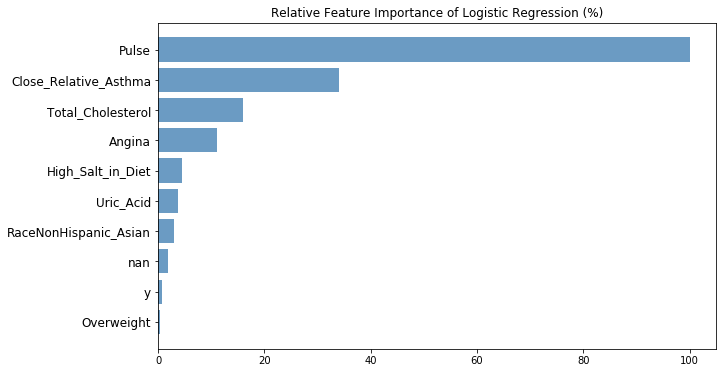

In [34]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(10,6))

share = feature_importance_table_desc[feature_importance_table_desc.columns[1]]
plt.barh(range(10), share, align = 'center',color='steelblue', alpha = 0.8)

plt.yticks(range(10),feature_importance_table_desc[feature_importance_table_desc.columns[0]], fontsize=12)
#ax.set_xlabels('Relative Feature Importance (%)')
#xticks(np.arange(10), ['Tom', 'Dick', 'Sue',]) 
#plt.tight_layout()   
plt.title('Relative Feature Importance of Logistic Regression (%)')
plt.show()

### XGBoost Tree

In [48]:
import xgboost
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

In [164]:


# find the best parameter

nmc = 100 

# set up dictionary for grid search
#  dictionary name must now include pipeline function name then __

n_estimators = 100
max_depth = range(3,10,2)
gamma = [i/10.0 for i in range(0,5)]
min_child_weight = range(1,6,2)

param_grid={'gamma': gamma,'max_depth': max_depth,'min_child_weight': min_child_weight}
# set up cross-validation shuffles
cvf = ShuffleSplit(test_size=0.2,n_splits=nmc,random_state=25)
# set up search
grid_search=GridSearchCV(XGBClassifier(),param_grid,cv=cvf,return_train_score=True)
# implement search
grid_search.fit(X,Y)
# move results into DataFrame
results = pd.DataFrame(grid_search.cv_results_)
print(results[['rank_test_score','mean_test_score','param_max_depth','param_min_child_weight','param_gamma']])


    rank_test_score  mean_test_score param_max_depth param_min_child_weight  \
0                11         0.921210               3                      1   
1                 9         0.921393               3                      3   
2                 4         0.921577               3                      5   
3                27         0.901632               5                      1   
4                25         0.904711               5                      3   
5                16         0.908194               5                      5   
6                50         0.878680               7                      1   
7                40         0.886673               7                      3   
8                31         0.894629               7                      5   
9                60         0.872374               9                      1   
10               54         0.876224               9                      3   
11               45         0.884803               9

In [37]:
# use best parameters: max_depth= 3, min_child_weight= 5, gamma=0.3
xgb = XGBClassifier(
 max_depth= 3, 
 min_child_weight= 5,
 gamma=0.3,
 learning_rate =0.1,
 n_estimators=1000,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1)


xgb.fit(X_train,Y_train)
print('Training score:', xgb.score(X_train,Y_train))
print('Testing score:',xgb.score(X_test,Y_test))


Training score: 0.9501965923984272
Testing score: 0.871638141809291


no severe overfitting problems

In [38]:
# confusion matrix
        
pred = xgb.predict(X_test)
confusion_matrix(y_true=Y_test, y_pred=pred)

array([[1420,  113],
       [  97,    6]])

In [39]:
print(classification_report(y_true=Y_test, y_pred=pred))

              precision    recall  f1-score   support

           0       0.94      0.93      0.93      1533
           1       0.05      0.06      0.05       103

    accuracy                           0.87      1636
   macro avg       0.49      0.49      0.49      1636
weighted avg       0.88      0.87      0.88      1636



# Risk Score

In [ ]:
risk_score = 100*xgb.predict_proba(X).reshape(-1,1)

In [13]:

reshaped_X_test = pd.DataFrame(X)
reshaped_X_test.index = np.arange(0,len(X))
reshaped_risk_score = pd.DataFrame(risk_score)

predictors_name = pd.DataFrame(data[data.columns[0:-1]].columns)
predictors_name.loc[predictors_name.index.max() + 1] = "Risk Score"
risk_score = pd.concat([reshaped_X_test,reshaped_risk_score], axis=1, ignore_index=True)
risk_score.columns = ['Gender','Age','RaceMexican_American','RaceOther_Hispanic','RaceNonHispanic_White','RaceNonHispanic_Black','RaceNonHispanic_Asian','Diabetes','No_(Pre)_Diabetes','BMI','Pulse','AVG_Systolic_Blood_Pressure','AVG_Diastolic_Blood_Pressure','Total_Cholesterol','Atherosclerosis_Index',' Complete_Blood_Count_with_5-part_Differential','Standard_Biochemistry_Profile','Uric_Acid','Angina','Close_Relative_Heart_Attack','Close_Relative_Asthma','Close_Relative_Diabetes','Overweight','Lack_Exercise','High_Salt_in_Diet','Hight_Fat/Calories','Risk_Score']
                     
risk_score.head()                

,Gender,Age,RaceMexican_American,RaceOther_Hispanic,RaceNonHispanic_White,RaceNonHispanic_Black,RaceNonHispanic_Asian,Diabetes,No_(Pre)_Diabetes,BMI,...,Uric_Acid,Angina,Close_Relative_Heart_Attack,Close_Relative_Asthma,Close_Relative_Diabetes,Overweight,Lack_Exercise,High_Salt_in_Diet,Hight_Fat/Calories,Risk_Score
0,0.0,62.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,27.8,...,4.2,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,99.341629
1,0.0,53.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,30.8,...,7.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.658372
2,0.0,78.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,28.8,...,7.3,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,99.988831
3,0.0,78.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,28.8,...,7.3,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.011169
4,1.0,72.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,28.6,...,4.9,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,62.661098


## Feature Importance

In [14]:
import shap
# print the JS visualization code to the notebook
shap.initjs()

In [15]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X)

## Visualize a single prediction

In [16]:
shap.force_plot(explainer.expected_value, shap_values[2,:], X_test.iloc[2,:])

In [217]:
shap.force_plot(explainer.expected_value, shap_values[:1636,:], X.iloc[:1636,:])

## SHAP Summary Plot
Rather than use a typical feature importance bar chart, we use a density scatter plot of SHAP values for each feature to identify how much impact each feature has on the model output for individuals in the validation dataset. Features are sorted by the sum of the SHAP value magnitudes across all samples. It is interesting to note that the relationship feature has more total model impact than the captial gain feature, but for those samples where capital gain matters it has more impact than age. In other words, capital gain effects a few predictions by a large amount, while age effects all predictions by a smaller amount.

Note that when the scatter points don't fit on a line they pile up to show density, and the color of each point represents the feature value of that individual.

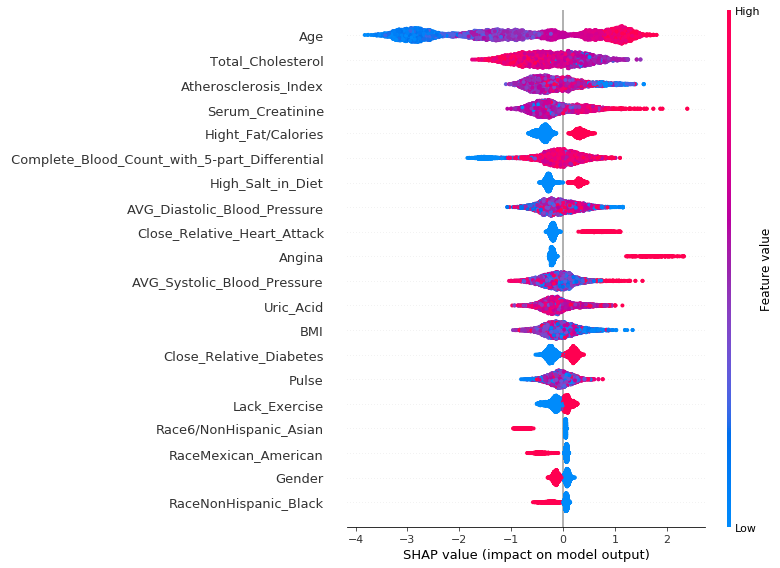

In [296]:
shap.summary_plot(shap_values, X)

## Bar chart of mean importance
This takes the average of the SHAP value magnitudes across the dataset and plots it as a simple bar chart.

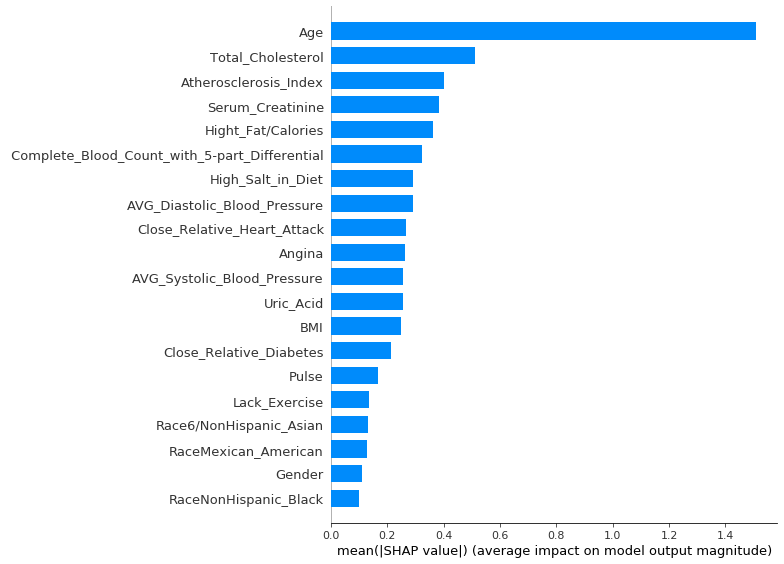

In [219]:
shap.summary_plot(shap_values, X, plot_type="bar")

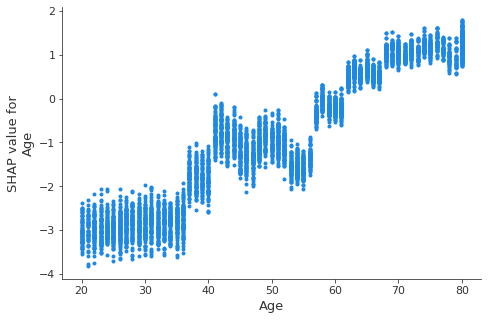

In [297]:
shap.dependence_plot('Age', shap_values, X, interaction_index=None, show=False)

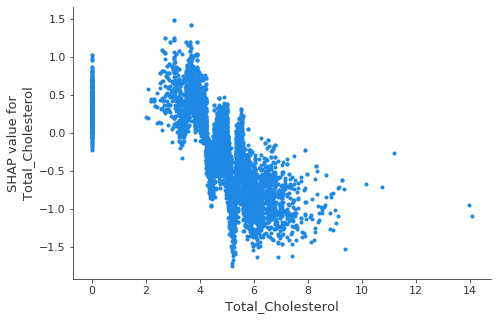

In [298]:
shap.dependence_plot('Total_Cholesterol', shap_values, X, interaction_index=None, show=False)

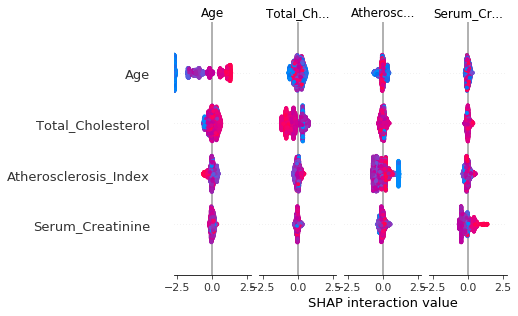

In [300]:
shap_interaction_values = shap.TreeExplainer(xgb).shap_interaction_values(X)
shap.summary_plot(shap_interaction_values, X, max_display=4)

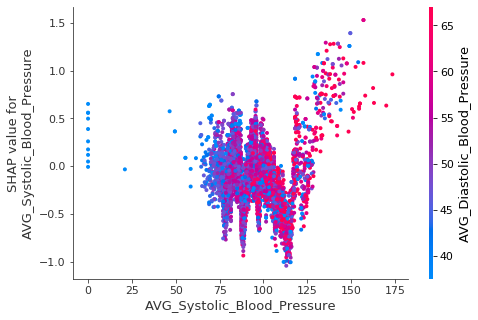

In [310]:
#Total_Cholesterol
shap.dependence_plot('AVG_Systolic_Blood_Pressure', shap_values, X, interaction_index='AVG_Diastolic_Blood_Pressure', show=False)

## DNN

Epoch 1/100
4/4 [==============================] - 0s 73ms/step - loss: 2701868.7500 - val_loss: 6.2958
Epoch 2/100
4/4 [==============================] - 0s 29ms/step - loss: 5948.9092 - val_loss: 6.2958
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 26)]              0         
_________________________________________________________________
input_bn (BatchNormalization (None, 26)                104       
_________________________________________________________________
first (Dense)                (None, 26)                702       
_________________________________________________________________
second (Dense)               (None, 64)                1728      
_________________________________________________________________
last (Dense)                 (None, 26)                1690      
____________________________________________________

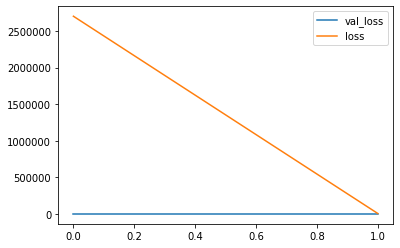

In [12]:

from keras.layers import Input, Dense, BatchNormalization 
from keras.models import Model 
from tensorflow.keras.callbacks import EarlyStopping
#from keras.callbacks import EarlyStopping 
# set input layer
inputs = Input(shape=(X_train.shape[1],), name='input') 
# normalized the batches 
x = BatchNormalization(name='input_bn')(inputs) 
# add the fully connected layers 
x = Dense(X_train.shape[1], activation='relu', name='first')(x) 
x = Dense(64, activation='relu',name='second')(x) 
x = Dense(X_train.shape[1], activation='elu',name='last')(x) 
# get the final result 
predictions = Dense(1, activation='relu', name='ouput')(x) 
# This creates a model that includes 
# the Input layer and three Dense layers
model = Model(inputs=inputs, outputs=predictions) 
model.compile(optimizer='adam', loss='mape') 
model.fit(X_train, Y_train, epochs = 100, batch_size = 1000, validation_data = (X_test,Y_test), shuffle=True, callbacks=[EarlyStopping(monitor='val_loss', patience=1,)]) 
#let's get the training and validation histories for plotting 
val_loss = model.history.history['val_loss'] 
loss = model.history.history['loss'] 
print(model.summary()) 
# let's plot the performance curve 
import matplotlib.pyplot as plt 
plt.figure() 
plt.plot(val_loss, label='val_loss') 
plt.plot(loss, label = 'loss') 
plt.legend() 
plt.show()



In [13]:
pred1 = model.predict(X_test)
confusion_matrix(y_true=Y_test, y_pred=pred1)

array([[1533,    0],
       [ 103,    0]])

In [14]:
pred_train = model.predict(X_train)
confusion_matrix(y_true=Y_train, y_pred=pred_train)

array([[3529,    0],
       [ 286,    0]])

In [15]:

print(classification_report(y_true=Y_train, y_pred=pred_train))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96      3529
           1       0.00      0.00      0.00       286

    accuracy                           0.93      3815
   macro avg       0.46      0.50      0.48      3815
weighted avg       0.86      0.93      0.89      3815



In [16]:
print(classification_report(y_true=Y_test, y_pred=pred1))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1533
           1       0.00      0.00      0.00       103

    accuracy                           0.94      1636
   macro avg       0.47      0.50      0.48      1636
weighted avg       0.88      0.94      0.91      1636



In [17]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values,feature_names=X_train.columns.values.tolist(),class_names=[Y_train.unique()])
predict_fn = lambda x: model.predict_proba(x).astype(float)
#exp = explainer.explain_instance(X_test.values[0], predict_fn, num_features=6)
#exp.show_in_notebook(show_all=False)


NameError: name 'lime' is not defined

In [396]:
model.predict_proba(x)

AttributeError: 'Model' object has no attribute 'predict_proba'

In [408]:

import lime 
import lime.lime_tabular 
from sklearn import linear_model 
# set up the LIME explain
explainer = lime.lime_tabular.LimeTabularExplainer(X_test, training_labels = Y_test.values, feature_names = X_test.columns, mode = 'classification', discretize_continuous = False) 
# you need to modify the output since keras outputs a tensor and LIME takes arrays 
def predict(x): return model.predict(x).flatten() 
# compute the explainer. Chose Huber for its robustness against outliers 
exp = explainer.explain_instance(X_test.values[1], predict, num_features=len(X_test.columns)) 
# generate plot for one item 
exp.show_in_notebook(show_table=True, predict_proba=True, show_predicted_value=True)



NotImplementedError: LIME does not currently support classifier models without probability scores. If this conflicts with your use case, please let us know: https://github.com/datascienceinc/lime/issues/16

In [367]:
explainer = lime.lime_tabular.LimeTabularExplainer(train ,feature_names = feature_names,class_names=class_names,
                                                   categorical_features=categorical_features, 
                                                   categorical_names=categorical_names, kernel_width=3)

NameError: name 'train' is not defined

In [37]:
import tensorflow as tf


feature_columns = []
for key in X_train.keys():
    feature_columns.append(tf.feature_column.numeric_column(key=key))
    
# Or estimator using the ProximalAdagradOptimizer optimizer with
# regularization.

optimizer_adam= tf.train.AdamOptimizer(learning_rate=0.01)
estimator=tf.estimator.DNNClassifier([9,9,3], feature_columns=feature_columns,  optimizer=optimizer_adam)
#estimator = tf.estimator.DNNClassifier(feature_columns=feature_columns,hidden_units=[1024, 512, 256],optimizer=tf.compat.v1.train.ProximalAdagradOptimizer(learning_rate=0.1,l1_regularization_strength=0.001))


 #   estimator.train(input_fn=get_test_inputs)
  #  metrics = estimator.evaluate(input_fn=get_test_inputs)
  #  predictions = estimator.predict(input_fn=input_fn_predict)

def train_input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((dict(X_train), Y_train))
    dataset = dataset.shuffle(1000).repeat().batch(10)
    return dataset

def eval_input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((dict(X_test), Y_test))
    return dataset.shuffle(1000).repeat().batch(10)    
    

estimator.train(input_fn=lambda: train_input_fn(), steps=2000)
eval_results = estimator.evaluate(input_fn=eval_input_fn, steps=1)

print('\nTest set accuracy: {accuracy:0.3f}\n'.format(**eval_result))



AttributeError: module 'tensorflow._api.v2.train' has no attribute 'AdamOptimizer'

In [ ]:
# Evaluate accuracy.
# print(classifier.evaluate(input_fn=get_test_inputs, steps=1))
accuracy_score = classifier.evaluate(input_fn=get_test_inputs, steps=1)["accuracy"]
graph_location = '/tmp/tensorflow/car-evaluation'
print('Saving graph to: %s' % graph_location)
train_writer = tf.summary.FileWriter(graph_location)
train_writer.add_graph(tf.get_default_graph())
print("Test Accuracy: {0:f}".format(accuracy_score))


In [23]:
X

,Gender,Age,RaceMexican American,RaceOther Hispanic,RaceNon-Hispanic White,RaceNon-Hispanic Black,Race6\tNon-Hispanic Asian,DIQ010Yes,DIQ010No,BMXBMI,...,LBXSCR,LBXSUA,MCQ160D,MCQ300A,MCQ300B,MCQ300C,MCQ365A,MCQ365B,MCQ365C,MCQ365D
0,0,62,0,0,1,0,0,1,0,27.8,...,0.90,4.2,0,0,0,1,0,1,0,0
1,0,53,0,0,1,0,0,0,1,30.8,...,1.05,7.0,0,0,0,1,0,0,0,0
2,0,78,0,0,1,0,0,1,0,28.8,...,1.12,7.3,0,0,1,0,0,1,1,1
3,0,78,0,0,1,0,0,1,0,28.8,...,1.12,7.3,0,0,1,0,0,1,1,1
4,1,72,1,0,0,0,0,0,1,28.6,...,1.15,4.9,0,0,0,1,0,0,0,1
5,0,22,0,0,0,1,0,0,1,28.0,...,0.73,6.0,0,1,0,1,0,0,0,0
6,1,32,1,0,0,0,0,0,1,28.2,...,0.60,5.2,0,0,0,1,0,0,0,0
7,0,56,0,0,0,1,0,1,0,33.6,...,1.37,4.8,0,0,0,1,1,1,1,1
8,0,56,0,0,0,1,0,1,0,33.6,...,1.37,4.8,0,0,0,1,1,1,1,1
9,0,45,0,0,0,0,0,0,1,24.1,...,0.81,5.4,0,0,0,0,0,0,0,1
